## 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

### 1. 필요한 모듈 import하기

In [65]:
import warnings
warnings.filterwarnings("ignore")
import xgboost
import lightgbm
import missingno
import sklearn

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# seaborn 기본 설정
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='NanumBarunGothic',
              rc=custom_params)

### 2. 데이터 준비

In [68]:
# 데이터 호출하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


In [69]:
# train과 test데이터 차이 확인
print(f"train 칼럼 갯수 : {len(train.columns)}, test 칼럼 갯수 : {len(test.columns)}")
set1 = set(list(train.columns))
set2 = set(list(test.columns))
print(f"train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {set1 - set2}")

train 칼럼 갯수 : 21, test 칼럼 갯수 : 20
train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {'price'}


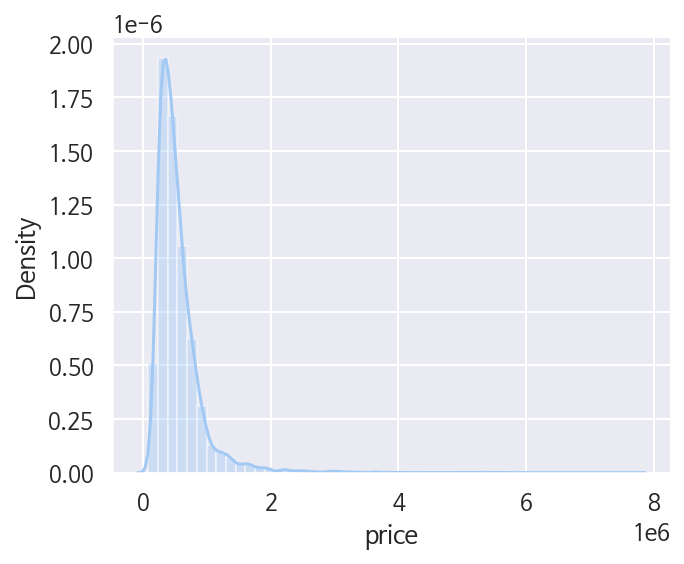

In [70]:
# price의 분포 확인
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(train['price'])
plt.show()

In [71]:
# price의 정규화 시 데이터의 정규분포여부 확인
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(np.log1p(train['price']), plot=plt)ㅋ

SyntaxError: invalid syntax (161588472.py, line 8)

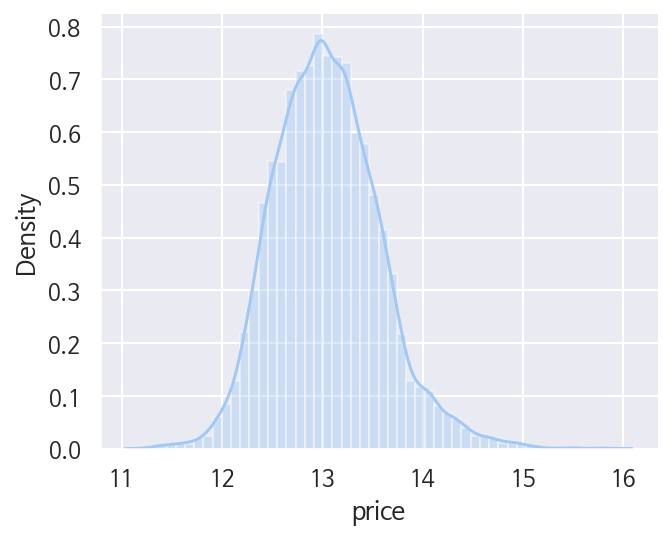

In [72]:
train['price'] = np.log1p(train['price'])
# 적용후 재 확인
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(train['price'])
plt.show()

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 가장 가까운 이웃 15명을 위한 인테리어 주택 거주 공간의 정방형 화면
21. sqft_lot15 : 가장 가까운 이웃 15명의 땅을 찍은 정방형 화면

### 3. 데이터 탐색 및 전처리

<AxesSubplot:>

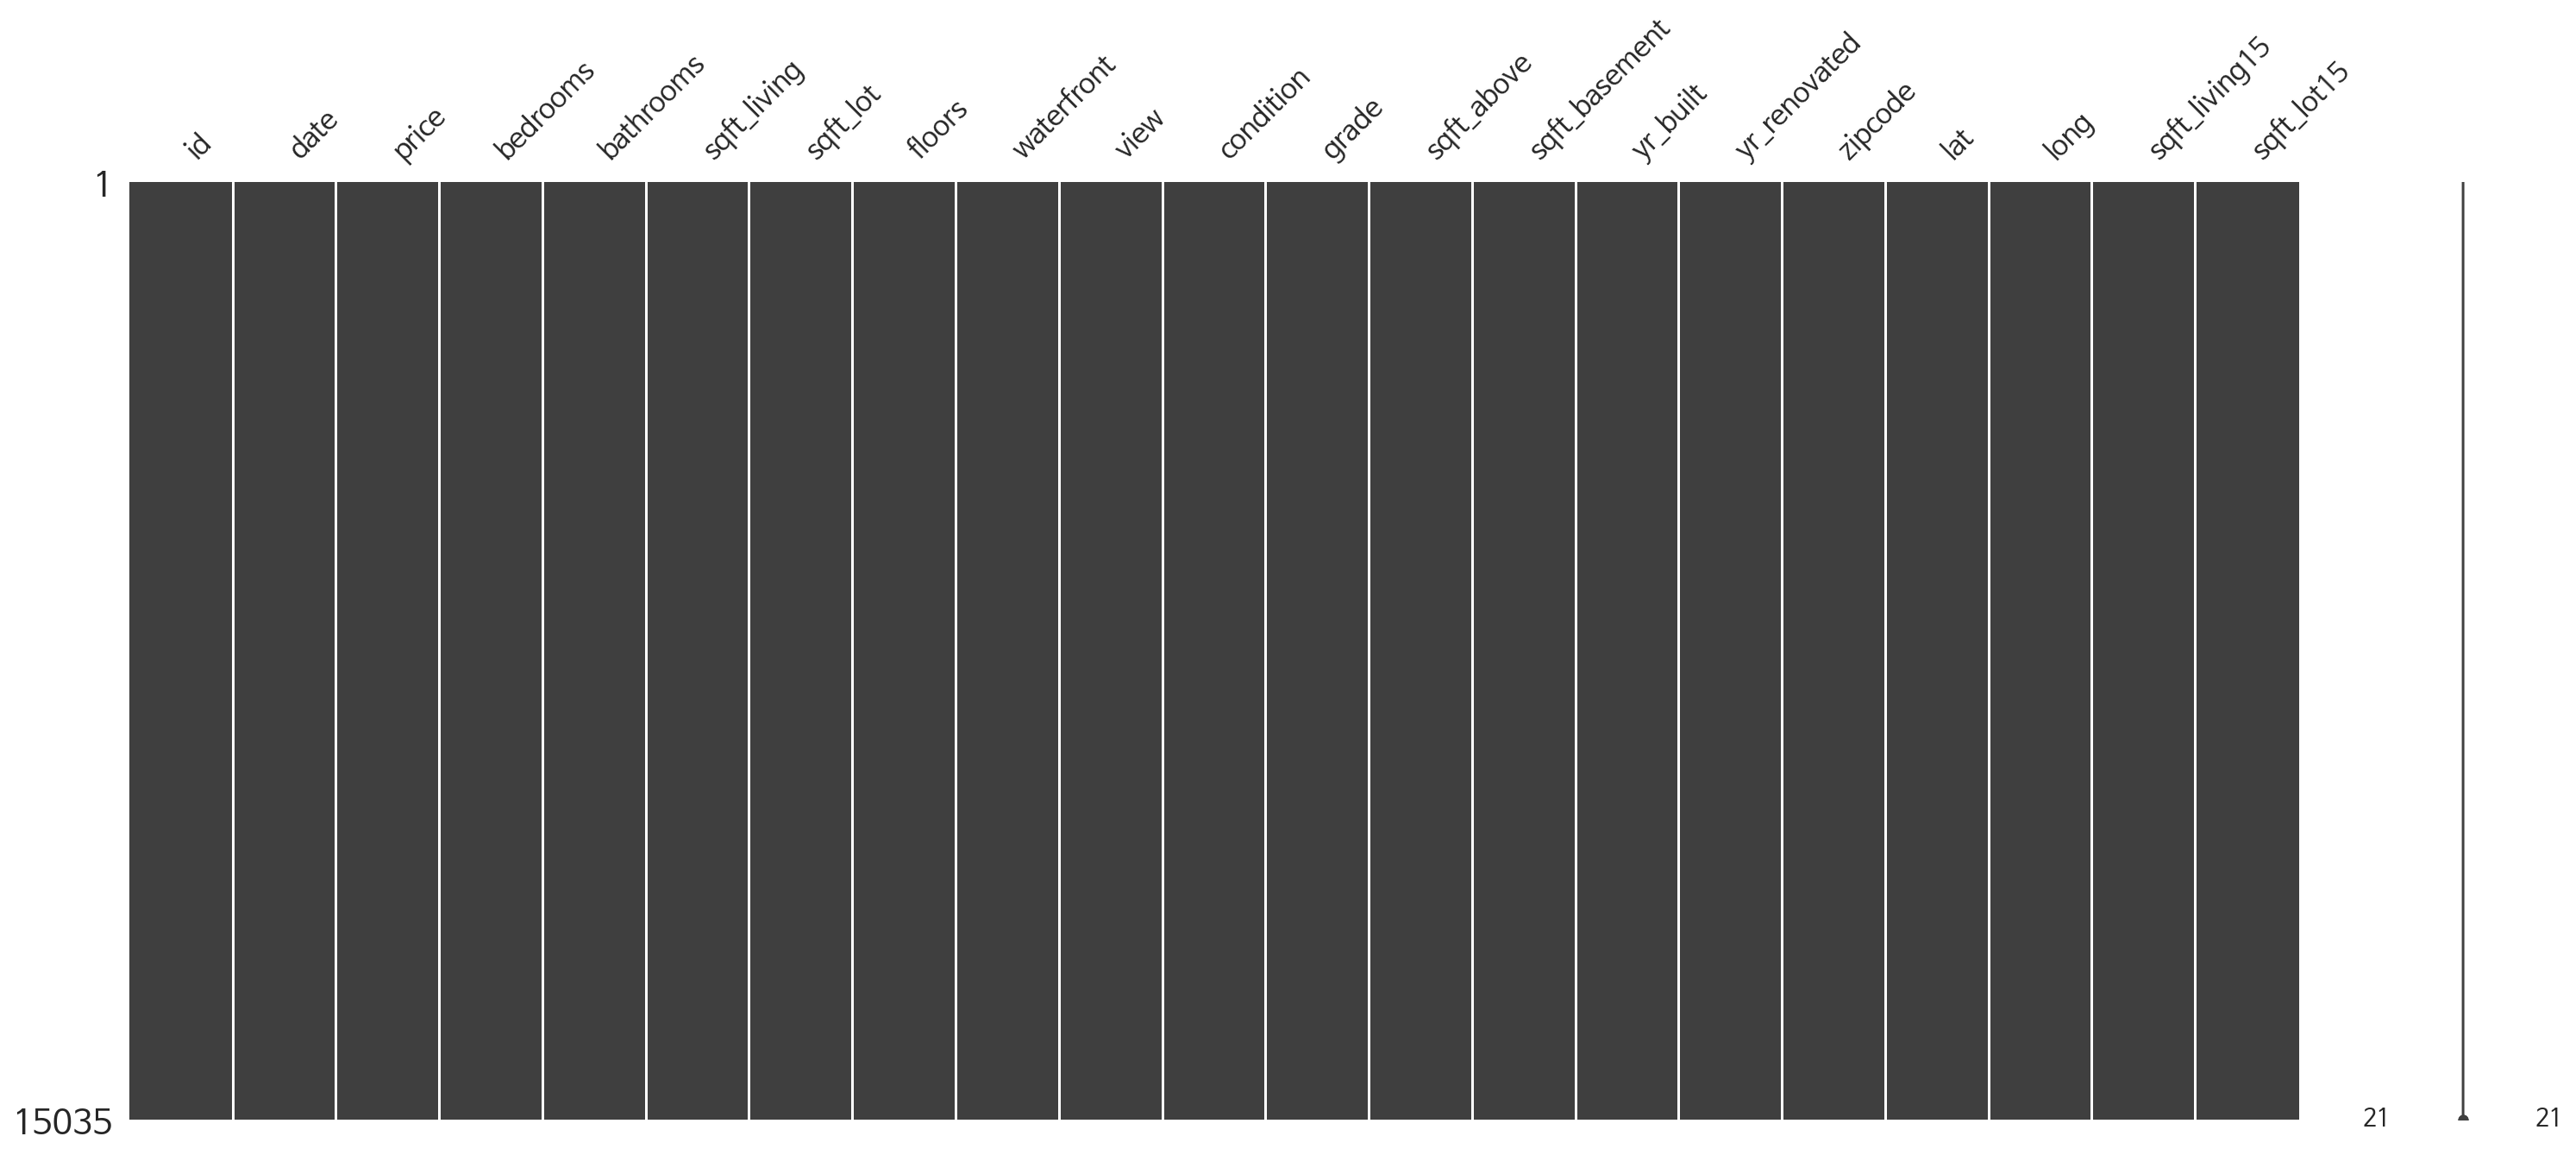

In [73]:
# 결측치 확인
msno.matrix(train)

In [74]:
sub_id = test['id']
def data_sol(col):
    for i in col:
        i['date'] = i['date'].apply(lambda x: x[:6]).astype(int)

data_sol([train, test])

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


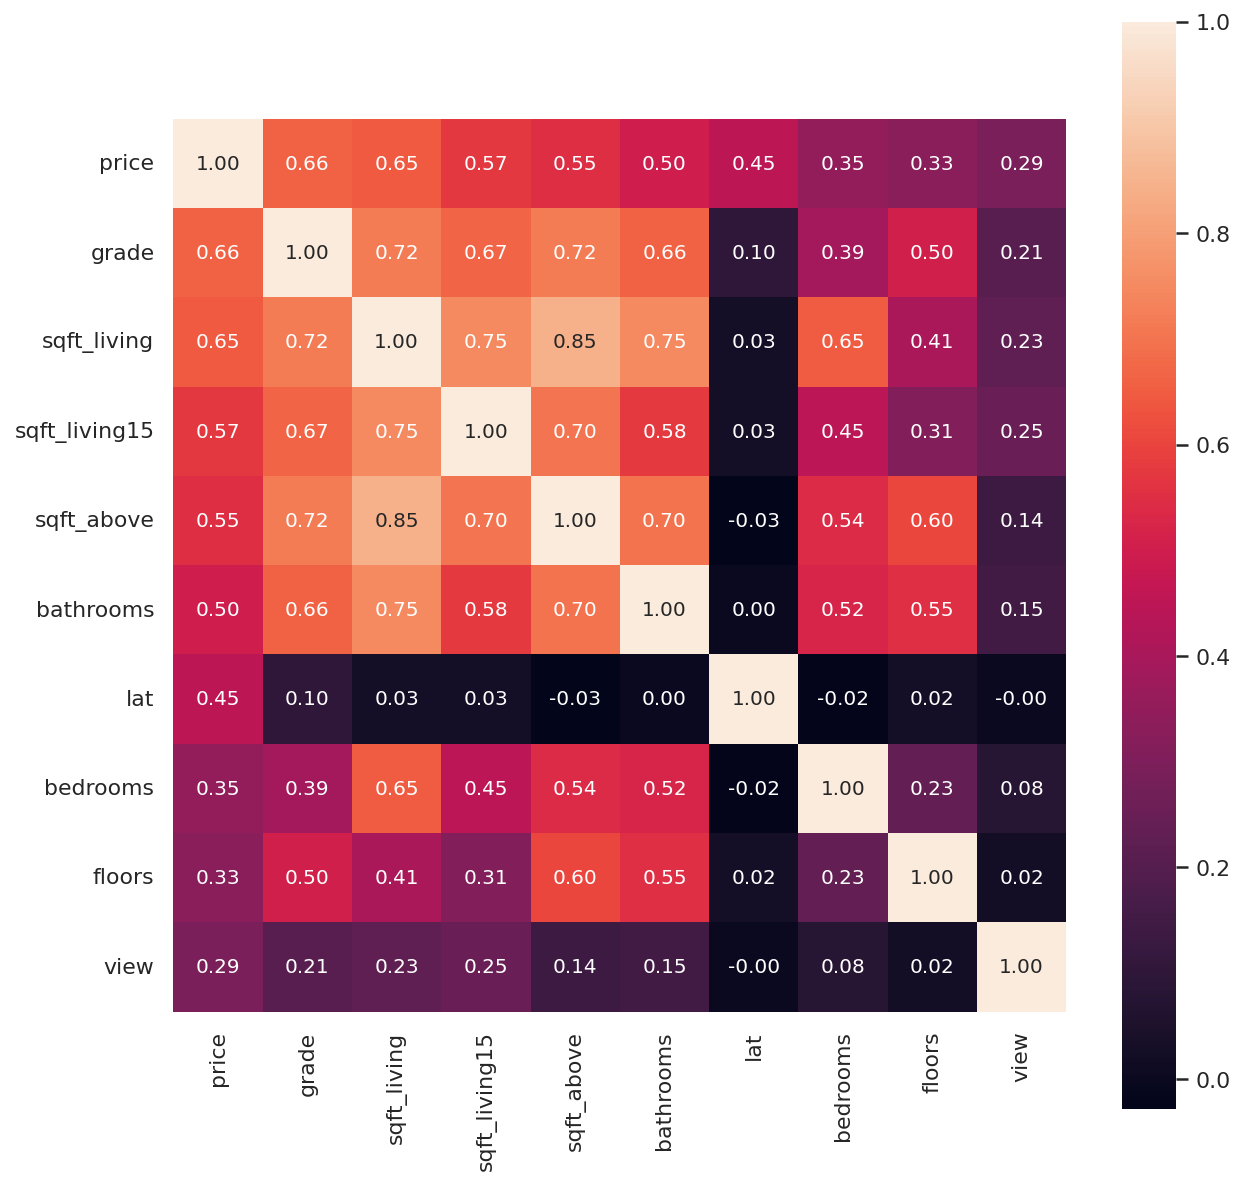

In [43]:
# correlation이 높은 상위 10개의 heatmap
# abs로 절대값으로 추출
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.show()

In [44]:
# 상관계수가 가장 높은 grade의 종류 확인
train['grade'].nunique()

12

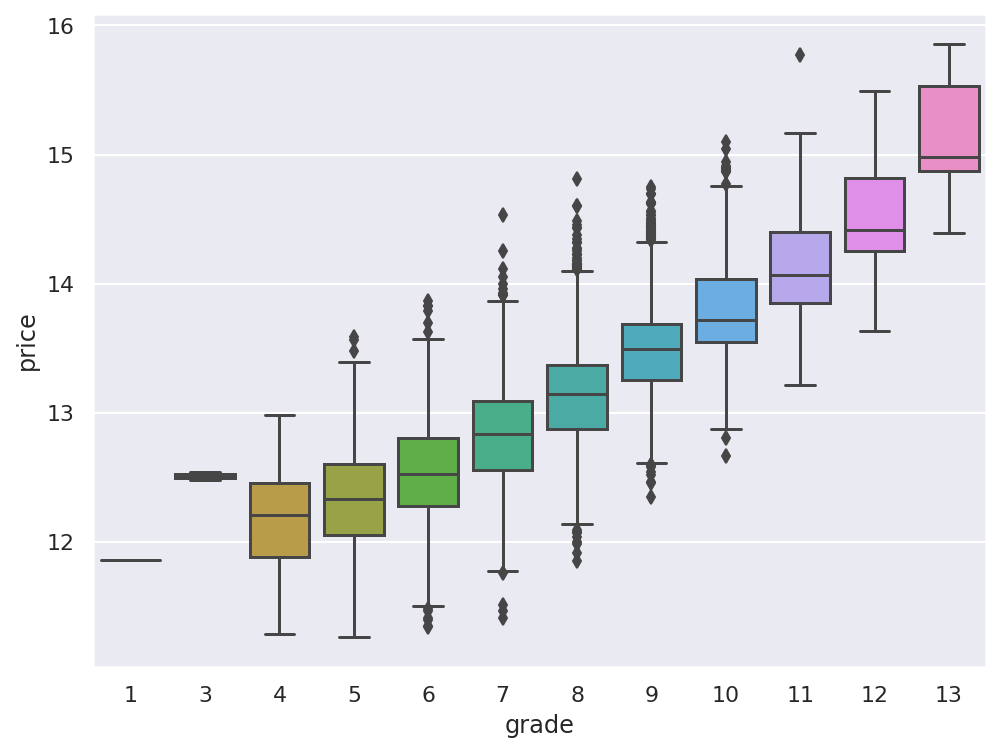

In [45]:
# grade를 기준으로 이상치 판단해보기 (boxplot사용)
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

In [46]:
# 1,3등급은 갯수가 적어보임
# 11등급에서 값이 이상한 이상치가 존재함
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [47]:
train.loc[train['grade'] == 3]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [48]:
train.loc[train['grade'] == 1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13522,13522,201409,11.863589,0,0.0,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [49]:
# 이상치로 판단 후 제거
# train = train.loc[train['id'] != 2302]
# train = train.loc[train['id'] != 4123]
# train = train.loc[train['id'] != 2775]
# train = train.loc[train['id'] != 13522]

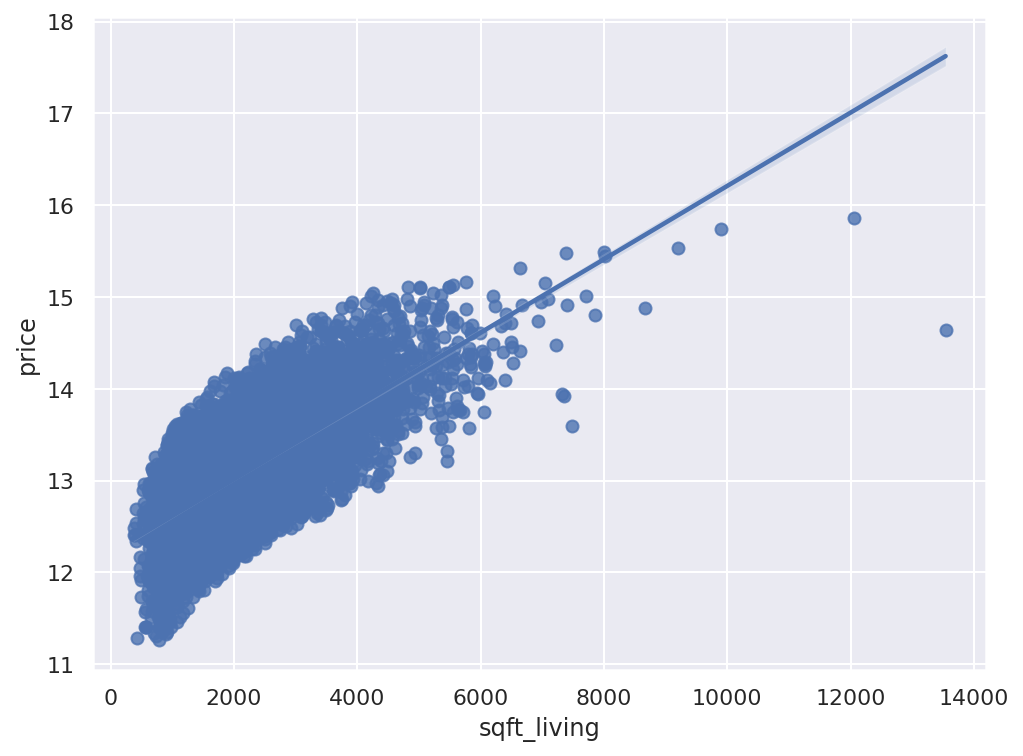

In [50]:
# 2번째로 상관계수가 높은 'sqft_living'을 기준으로 이상치 판단해보기 (regplot 사용)
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [51]:
# 13000이 넘어가는 한 점을 이상치로 판단 후 제거
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [52]:
# train = train.loc[train['id'] != 8912]

In [78]:
# target 분리
y = train['price']
del train['price']

sub_id = test['id']
del train['id']
del test['id']

In [79]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 4. 모델링

**블렌딩(blending)**: 여러 가지 모델을 함께 사용해서 결과를 섞는 기법  

**보팅**: 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법 => **분류**  
**에버리징**: 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법 => **회귀**


회귀 문제를 풀고 있으므로, 위 분류기의 앙상블처럼 투표로 정하는 대신 예측 결과를 평균 내어 활용할 예정

In [54]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [55]:
random_state=2020 # 고정값 세팅

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [59]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

    model.fit(X_train, y_train) # 모델 학습
    y_pred = model.predict(X_test) # 예측

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 137857.88471139254,
 'XGBRegressor': 119210.68157287971,
 'LGBMRegressor': 118848.84927018393,
 'RandomForestRegressor': 130117.57011937568}

In [17]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [18]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [32]:
param_grid = {
    'max_depth': [5, 10, 15],                   # 의사 결정 나무의 깊이 후보값
    'learning_rate': [0.01, 0.1],       # 학습률 후보값
    'n_estimators': [1500, 1600],             # 개별 모델의 개수 후보값
    'boosting_type': ['gbdt']            # 부스팅 방식 후보값
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
5,gbdt,0.01,15,1600,-0.026074,0.161475
3,gbdt,0.01,10,1600,-0.026108,0.161579
4,gbdt,0.01,15,1500,-0.026135,0.161664
2,gbdt,0.01,10,1500,-0.026168,0.161765
8,gbdt,0.10,10,1500,-0.027106,0.164638
9,gbdt,0.10,10,1600,-0.027152,0.164779
6,gbdt,0.10,5,1500,-0.027277,0.165158
10,gbdt,0.10,15,1500,-0.027297,0.165217
1,gbdt,0.01,5,1600,-0.027308,0.165253
11,gbdt,0.10,15,1600,-0.027346,0.165366


* 그리드서치로 최적의 하이퍼 파라미터를 찾은 후 RMSLE 값이 가장 낮은 파라미터 값을 적용한 모델만 가지고 훈련해보기

### 5. 제출

In [75]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [80]:
# 최적의 하이퍼 파라미터 설정
model = LGBMRegressor(max_depth=15, n_estimators=1600, 
                      learning_rate=0.1, boosting_type='gbdt', random_state=random_state)

In [81]:
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.1801591 , 13.09490333, 14.00478688, ..., 13.08232139,
       12.71009727, 13.00806004])

In [82]:
prediction = np.expm1(prediction)
prediction

array([ 529748.2695529 ,  486455.77841028, 1208373.81192588, ...,
        480373.54733477,  331073.02348763,  445992.6689374 ])

In [83]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161475')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbmm_RMSLE_0.161475.csv saved!


### private 점수 증거 자료
<img src="https://i.ibb.co/VMLJ6TT/0919.jpg">

## 중요포인트--

* 이상치를 삭제하는 전처리 과정에서 주석처리가 되어있는데 전처리 후 제출 시 점수가 오히려 안 좋아지는 현상이 발생
* 전처리 없이 하이퍼 파라미터만 조정해 보았으나 오히려 점수가 11만점보다 이하로 나옴
* 해서 상관관계에 의한 시각화를 해보았으나 전처리에 쓰이지 않음이 유리함